In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
import time
import os
import os
os.environ['NLTK_DATA'] = '/tmp/nltk_data'

In [2]:
# Function for scraping headlines using BeautifulSoup
def scrape_real_news(url, selector, pages=50, source="Unknown"):
    headlines = []
    for page in tqdm(range(1, pages+1), desc=source):
        try:
            page_url = url.format(page)
            res = requests.get(page_url)
            soup = BeautifulSoup(res.text, 'html.parser')
            for h in soup.select(selector):
                text = h.get_text(strip=True)
                headlines.append({"headline": text, "label": "real", "source": source})
        except Exception as e:
            print(f"Error on page {page} of {source}: {e}")
    return headlines

real_sources = [
    {"source": "The Hindu", "url": "https://www.thehindu.com/latest-news/?page={}", "selector": "h3.title"},
    {"source": "NDTV", "url": "https://www.ndtv.com/latest/page-{}", "selector": "h2.newsHdng"},
    {"source": "TOI", "url": "https://timesofindia.indiatimes.com/briefs?page={}", "selector": "h2"},
    {"source": "Indian Express", "url": "https://indianexpress.com/section/india/page/{}/", "selector": "h2.title"},
    {"source": "Hindustan Times", "url": "https://www.hindustantimes.com/latest-news/page-{}", "selector": "h3.hdg3"},
    {"source": "India Today", "url": "https://www.indiatoday.in/latest-news?page={}", "selector": "h2.news-title"},
]

real_news = []
for src in real_sources:
    real_news += scrape_real_news(src['url'], src['selector'], pages=100, source=src['source'])

df_real = pd.DataFrame(real_news)
df_real.to_csv("data/raw_real_news.csv", index=False)
print(df_real.head())
print(df_real.shape)

India Today: 100%|█████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]

                                            headline label     source
0  Rules for Cubbon Park: Government Order specif...  real  The Hindu
1  The tale of Bharatha Matha temple, a pet proje...  real  The Hindu
2  Israeli minister says 'Gaza will be entirely d...  real  The Hindu
3  University College students chosen for researc...  real  The Hindu
4            Fuel station manager robbed of ₹34 lakh  real  The Hindu
(9206, 3)


In [8]:
import feedparser
import pandas as pd

def scrape_ndtv_rss():
    feed_url = "https://feeds.feedburner.com/ndtvnews-latest"
    feed = feedparser.parse(feed_url)
    
    articles = []
    for entry in feed.entries:
        articles.append({
            "headline": entry.title,
            "label": "real",
            "source": "NDTV"
        })
    return articles

ndtv_data = scrape_ndtv_rss()
df_ndtv = pd.DataFrame(ndtv_data)
df_ndtv.to_csv("data/ndtv_real_news.csv", index=False)
print(df_ndtv.head())

                                            headline label source
0  "Never Say Never": Trump To Carney's Canada Wi...  real   NDTV
1  "Absurd": India Strongly Rejects Islamic Bloc'...  real   NDTV
2  T-Rex Luxury Bags? Scientists Plan To Use Leat...  real   NDTV
3  NSG Commandos Visits Puri Jagannath Temple, Re...  real   NDTV
4  US Woman With Stage 4, Incurable Colon Cancer ...  real   NDTV


In [10]:
import feedparser
import pandas as pd

def scrape_rss_feed(feed_url, source_name):
    feed = feedparser.parse(feed_url)
    articles = []
    for entry in feed.entries:
        articles.append({
            "headline": entry.title,
            "label": "real",
            "source": source_name
        })
    return articles

# Define RSS feed URLs
rss_feeds = [
    {"url": "https://www.indiatoday.in/rss/home", "source": "India Today"},
    {"url": "https://www.hindustantimes.com/rss/topnews/rssfeed.xml", "source": "Hindustan Times"}
]

# Collect articles from all feeds
all_articles = []
for feed in rss_feeds:
    articles = scrape_rss_feed(feed["url"], feed["source"])
    all_articles.extend(articles)

# Create DataFrame and save to CSV
df_real_news = pd.DataFrame(all_articles)
df_real_news.to_csv("data/real_news_rss.csv", index=False)
print(df_real_news.head())

                                            headline label       source
0  India's water used to go outside but now...: P...  real  India Today
1  Over 50 locations in Delhi to witness security...  real  India Today
2  In meet with Trump, Carney says Canada not for...  real  India Today
3  Air Force plans large-scale drill along border...  real  India Today
4  Masterstroke or damage-control? BJP's caste ce...  real  India Today


In [32]:
import time
import pandas as pd
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.firefox.options import Options

# Setup headless Firefox browser
options = Options()
options.headless = True
driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)

def scrape_headlines(url_template, selector, pages, source_name):
    data = []
    for page in tqdm(range(1, pages + 1), desc=source_name):
        try:
            url = url_template.format(page)
            driver.get(url)
            time.sleep(2.5)
            elements = driver.find_elements(By.CSS_SELECTOR, selector)
            for el in elements:
                text = el.text.strip()
                if text:
                    data.append({
                        "headline": text,
                        "label": "real",
                        "source": source_name
                    })
        except Exception as e:
            print(f"⚠️ Error on {source_name} page {page}: {e}")
    return data

# Define real sources
real_sources = [
    {
        "source": "India Today",
        "url": "https://www.indiatoday.in/latest-news?page={}",
        "selector": "h2"
    }
]

# Scrape data
all_real_news = []
for src in real_sources:
    headlines = scrape_headlines(src['url'], src['selector'], pages=60, source_name=src['source'])
    all_real_news.extend(headlines)

# Close the browser
driver.quit()

# Save to CSV
df_real = pd.DataFrame(all_real_news)
df_real.to_csv("data/indiatoday_real_news.csv", index=False)
print(df_real.head())
print("✅ Total headlines collected:", df_real.shape[0])

India Today: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.96s/it]


                                            headline label       source
0  IPL 2025: GT win rain-affected thriller to hur...  real  India Today
1  Pisces Daily Horoscope Today (Feb 19-Mar 20), ...  real  India Today
2  Aquarius Daily Horoscope Today (Jan 20- Feb 18...  real  India Today
3  Capricorn Daily Horoscope Today (Dec 22-Jan 19...  real  India Today
4  Sagittarius Daily Horoscope Today (Nov 22 - De...  real  India Today
✅ Total headlines collected: 12


In [44]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm

def scrape_deccan_herald(pages=100):
    headlines = []
    for page in tqdm(range(1, pages+1), desc="Deccan Herald"):
        try:
            url = f"https://www.deccanherald.com/latest-news?page={page}"
            res = requests.get(url)
            soup = BeautifulSoup(res.text, 'html.parser')
            for h in soup.select('h2.headline'):
                text = h.get_text(strip=True)
                if text:
                    headlines.append({"headline": text, "label": "real", "source": "Deccan Herald"})
        except Exception as e:
            print(f"⚠️ Error on page {page}: {e}")
    return headlines

def scrape_scroll_in(pages=100):
    headlines = []
    for page in tqdm(range(1, pages+1), desc="Scroll.in"):
        try:
            url = f"https://scroll.in/latest?page={page}"
            res = requests.get(url)
            soup = BeautifulSoup(res.text, 'html.parser')
            for h in soup.select('h1'):
                text = h.get_text(strip=True)
                if text:
                    headlines.append({"headline": text, "label": "real", "source": "Scroll.in"})
        except Exception as e:
            print(f"⚠️ Error on page {page}: {e}")
    return headlines

# Scrape both sources
deccan = scrape_deccan_herald(pages=100)
scroll = scrape_scroll_in(pages=100)

# Combine and save
df = pd.DataFrame(deccan + scroll)
df.to_csv("data/deccan_scroll_real_news.csv", index=False)

print("✅ Total headlines collected:", len(df))
print(df.head())

Scroll.in: 100%|███████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]

✅ Total headlines collected: 5700
                                            headline label         source
0  Pakistan Army vows to 'respond' as India strik...  real  Deccan Herald
1  India launches 'Operation Sindoor', hit terror...  real  Deccan Herald
2  Yellow Line: 3 more coaches on way to Bengalur...  real  Deccan Herald
3  21-yr-old graduate held for stealing 325 gm go...  real  Deccan Herald
4                  Eye screening camp for BMTC staff  real  Deccan Herald


In [43]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.firefox import GeckoDriverManager
import pandas as pd
import time

# Setup headless Firefox browser
options = Options()
options.headless = True
driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)

# ---------- THE WIRE (View More Button Based) ----------
driver.get("https://thewire.in/category/politics/all")
time.sleep(3)

for i in range(50):  # Click 'View More' 30 times
    try:
        view_more_button = WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'View More')]"))
        )
        driver.execute_script("arguments[0].scrollIntoView();", view_more_button)
        view_more_button.click()
        time.sleep(2.5)
    except:
        print(f"Stopped at click {i}")
        break

wire_elements = driver.find_elements(By.CSS_SELECTOR, "div.side-article-title-mc")
wire_data = [{"headline": el.text.strip(), "label": "real", "source": "The Wire"} for el in wire_elements if el.text.strip()]

# ---------- LIVEMINT ----------
livemint_data = []
for page in range(1, 70):
    driver.get(f"https://www.livemint.com/latest-news/page-{page}")
    time.sleep(2.5)
    elements = driver.find_elements(By.CSS_SELECTOR, "h2.headline")
    for el in elements:
        text = el.text.strip()
        if text:
            livemint_data.append({"headline": text, "label": "real", "source": "LiveMint"})

# ---------- NEWS18 ----------
news18_data = []
for page in range(1, 70):
    driver.get(f"https://www.news18.com/latest/page-{page}")
    time.sleep(2.5)
    elements = driver.find_elements(By.CSS_SELECTOR, "figcaption")
    for el in elements:
        text = el.text.strip()
        if text:
            news18_data.append({"headline": text, "label": "real", "source": "News18"})

# Close browser
driver.quit()

# Combine and save
all_data = wire_data + livemint_data + news18_data
df = pd.DataFrame(all_data)
df = df[df['headline'].str.contains(r'[a-zA-Z]', na=False)].drop_duplicates(subset='headline')
df.to_csv("real_news_wire_livemint_news18.csv", index=False)

print("✅ Collected:", df.shape[0])

Stopped at click 0
✅ Collected: 2380


In [46]:
import pandas as pd
import re
import os

# Use absolute or correct relative paths
files = [
    "data/deccan_scroll_real_news.csv",
    "data/real_news_cleaned_english_only.csv",
    "data/real_news_wire_livemint_news18.csv",
    "data/indiatoday_real_news.csv",
    "data/ndtv_real_news.csv",
    "data/hindustan_times_indiatoday_real_news.csv",
]

# Load and merge all
dfs = [pd.read_csv(file) for file in files]
df_combined = pd.concat(dfs, ignore_index=True)

# Drop missing or empty headlines
df_combined.dropna(subset=["headline"], inplace=True)
df_combined = df_combined[df_combined["headline"].str.strip() != ""]

# Keep only English headlines
df_combined = df_combined[df_combined["headline"].str.contains(r"[a-zA-Z]", na=False)]

# Remove exact duplicates
df_combined.drop_duplicates(subset="headline", inplace=True)

# Remove headlines like "The Latest"
df_combined = df_combined[df_combined["headline"].str.strip().str.lower() != "the latest"]

# Reset index
df_combined.reset_index(drop=True, inplace=True)

# Save final clean dataset
df_combined.to_csv("data/Cleaned_Real_News_Dataset.csv", index=False)

print("✅ Cleaned and saved as 'Cleaned_Real_News_Dataset.csv'")
print("🔢 Final headline count:", df_combined.shape[0])

✅ Cleaned and saved as 'Cleaned_Real_News_Dataset.csv'
🔢 Final headline count: 8821


In [ ]:
print(model.classifier.weight)

In [47]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

# Your NewsAPI key
API_KEY = '6c5a1930497b442d8aa506fb93db707f'  # Replace with your actual API key

# Base URL for the NewsAPI 'everything' endpoint
BASE_URL = 'https://newsapi.org/v2/everything'

# Parameters
query = 'India'
language = 'en'
page_size = 100  # Maximum allowed
from_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')  # Last 7 days
to_date = datetime.now().strftime('%Y-%m-%d')

# Initialize variables
all_articles = []
for page in range(1, 101):  # NewsAPI allows up to 100 pages
    params = {
        'q': query,
        'language': language,
        'from': from_date,
        'to': to_date,
        'sortBy': 'publishedAt',
        'pageSize': page_size,
        'page': page,
        'apiKey': API_KEY
    }
    response = requests.get(BASE_URL, params=params)
    data = response.json()
    
    # Check for errors
    if data.get('status') != 'ok':
        print(f"Error fetching page {page}: {data.get('message')}")
        break
    
    articles = data.get('articles', [])
    if not articles:
        # No more articles to fetch
        break
    
    all_articles.extend(articles)
    
    # Respect rate limits
    time.sleep(1)  # Sleep for 1 second between requests

# Create a DataFrame
df = pd.DataFrame(all_articles)

# Save to CSV
df.to_csv('indian_news_headlines.csv', index=False)
print(f"Fetched {len(df)} articles and saved to 'indian_news_headlines.csv'")

Error fetching page 2: You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results.
Fetched 100 articles and saved to 'indian_news_headlines.csv'


In [51]:
import pandas as pd

# File paths
kaggle_path = "data/india-news-headlines.csv"  # Replace with your Kaggle CSV path
mine_path = "data/Cleaned_Real_News_Dataset.csv"  # Replace with your dataset path

# Load your cleaned dataset
df_mine = pd.read_csv(mine_path)

# Load Kaggle data in chunks
chunks = []
for chunk in pd.read_csv(kaggle_path, chunksize=100000):
    chunk['publish_date'] = chunk['publish_date'].astype(str)
    # Filter years from 2015 to 2023 based on first 4 digits
    chunk = chunk[chunk['publish_date'].str[:4].astype(int).between(2015, 2023)]
    chunks.append(chunk[['headline_text']])

# Combine filtered Kaggle chunks
df_kaggle = pd.concat(chunks, ignore_index=True)

# Clean Kaggle data
df_kaggle.dropna(subset=['headline_text'], inplace=True)
df_kaggle = df_kaggle[df_kaggle['headline_text'].str.strip() != ""]
df_kaggle.drop_duplicates(subset=['headline_text'], inplace=True)

# Limit to required number of rows
needed = 30000 - len(df_mine)
df_kaggle = df_kaggle.head(needed)

# Match structure: headline, label, source
df_kaggle.rename(columns={'headline_text': 'headline'}, inplace=True)
df_kaggle['label'] = 'real'
df_kaggle['source'] = 'Kaggle'

# Combine with your dataset
df_final = pd.concat([df_mine, df_kaggle], ignore_index=True)
df_final.reset_index(drop=True, inplace=True)

# Save
df_final.to_csv("final_real_news_merged.csv", index=False)

print("✅ Final combined dataset saved as 'final_real_news_merged.csv'")
print("📰 Total headlines:", df_final.shape[0])

✅ Final combined dataset saved as 'final_real_news_merged.csv'
📰 Total headlines: 30000


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your cleaned and labeled data
df = pd.read_csv("Balanced_Tagged_Subset_Cleaned.csv")

# Split into train and validation (80/20)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)

# Save
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)

print("✅ Train size:", len(train_df))
print("✅ Validation size:", len(val_df))
print("🔢 Categories:", df['category'].nunique())

✅ Train size: 1632
✅ Validation size: 408
🔢 Categories: 15


In [39]:
import shutil
shutil.rmtree("distilbert_15class_fast", ignore_errors=True)

In [1]:
# Optimized Fast Training Script for DistilBERT on M1 (3 Epochs) with Checkpoints

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
import pandas as pd
import os
import time

# Load data
train_df = pd.read_csv("train_data.csv")
val_df = pd.read_csv("val_data.csv")

# Encode labels
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['category'])
val_df['label'] = le.transform(val_df['category'])

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Dataset class
class NewsDataset(Dataset):
    def __init__(self, headlines, labels):
        self.encodings = tokenizer(headlines, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# DataLoaders with smaller batch size to reduce memory pressure
train_dataset = NewsDataset(train_df['headline'].tolist(), train_df['label'].tolist())
val_dataset = NewsDataset(val_df['headline'].tolist(), val_df['label'].tolist())
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=15)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Warm-up MPS (optional)
dummy_input = tokenizer("Test sentence", return_tensors="pt").to(device)
_ = model(**dummy_input)
print("✅ MPS warm-up complete")

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Create checkpoint folder
os.makedirs("checkpoints", exist_ok=True)

# Train 3 epochs with validation loss + F1 + full report
for epoch in range(3):
    model.train()
    total_loss = 0
    start_time = time.time()
    loop = tqdm(train_loader, leave=True, desc=f"Epoch {epoch}")

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} - Train Loss: {avg_train_loss:.4f} | Time: {time.time() - start_time:.2f}s")

    # Validation + Full Classification Report
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Epoch {epoch} - Val Loss: {avg_val_loss:.4f}, F1: {val_f1:.4f}")

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=le.classes_))

    # Save checkpoint after each epoch
    checkpoint_dir = f"checkpoints/epoch_{epoch}"
    os.makedirs(checkpoint_dir, exist_ok=True)
    model.save_pretrained(checkpoint_dir)
    tokenizer.save_pretrained(checkpoint_dir)
    print(f"✅ Checkpoint saved at {checkpoint_dir}")

# Save final model
model.save_pretrained("distilbert_15class_fast")
tokenizer.save_pretrained("distilbert_15class_fast")
print("✅ Training complete. Final model saved.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ MPS warm-up complete


Epoch 0:   0%|                                               | 0/204 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 0: 100%|█████████████████████████████████████| 204/204 [00:41<00:00,  4.89it/s]


Epoch 0 - Train Loss: 1.4698 | Time: 41.72s
Epoch 0 - Val Loss: 0.5890, F1: 0.8577

📊 Classification Report:
                precision    recall  f1-score   support

      business       1.00      0.63      0.77        27
         crime       0.96      0.85      0.90        27
     education       0.90      0.70      0.79        27
 entertainment       0.91      0.75      0.82        28
   environment       0.87      0.96      0.91        27
        health       0.93      1.00      0.96        27
infrastructure       0.97      1.00      0.98        28
 international       0.79      0.81      0.80        27
      politics       0.68      0.78      0.72        27
      religion       0.81      0.93      0.86        27
       science       0.89      0.93      0.91        27
 social issues       0.75      0.89      0.81        27
        sports       0.66      0.75      0.70        28
    technology       0.93      0.96      0.95        27
       weather       1.00      0.93      0.96     

Epoch 1: 100%|█████████████████████████████████████| 204/204 [00:40<00:00,  5.07it/s]


Epoch 1 - Train Loss: 0.3235 | Time: 40.26s
Epoch 1 - Val Loss: 0.3111, F1: 0.9262

📊 Classification Report:
                precision    recall  f1-score   support

      business       1.00      0.89      0.94        27
         crime       0.96      0.89      0.92        27
     education       0.92      0.85      0.88        27
 entertainment       0.90      0.96      0.93        28
   environment       0.90      0.96      0.93        27
        health       1.00      1.00      1.00        27
infrastructure       0.93      0.93      0.93        28
 international       0.89      0.89      0.89        27
      politics       0.81      0.78      0.79        27
      religion       0.93      0.93      0.93        27
       science       0.93      1.00      0.96        27
 social issues       0.84      1.00      0.92        27
        sports       0.96      0.86      0.91        28
    technology       0.96      0.96      0.96        27
       weather       1.00      1.00      1.00     

Epoch 2: 100%|█████████████████████████████████████| 204/204 [00:43<00:00,  4.74it/s]


Epoch 2 - Train Loss: 0.1336 | Time: 43.03s
Epoch 2 - Val Loss: 0.3880, F1: 0.9062

📊 Classification Report:
                precision    recall  f1-score   support

      business       1.00      0.89      0.94        27
         crime       0.90      0.96      0.93        27
     education       0.95      0.78      0.86        27
 entertainment       0.93      1.00      0.97        28
   environment       0.96      0.89      0.92        27
        health       0.93      1.00      0.96        27
infrastructure       0.96      0.96      0.96        28
 international       0.85      0.85      0.85        27
      politics       0.71      0.74      0.73        27
      religion       0.87      0.96      0.91        27
       science       0.90      0.96      0.93        27
 social issues       0.83      0.93      0.88        27
        sports       0.88      0.75      0.81        28
    technology       1.00      0.93      0.96        27
       weather       0.96      1.00      0.98     

In [19]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os

# Load the 30K real news file
df_real = pd.read_csv("Final_Fake_News_Dataset.csv")
df_real.dropna(subset=["headline"], inplace=True)

# Load label encoder from training data
train_df = pd.read_csv("train_data.csv")
le = LabelEncoder()
le.fit(train_df['category'])  # this contains the 15 category labels

# Load model and tokenizer
model_path = "distilbert_15class_fast"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define prediction function
def predict_category(texts):
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    encodings = {k: v.to(device) for k, v in encodings.items()}
    with torch.no_grad():
        outputs = model(**encodings)
    preds = torch.argmax(outputs.logits, dim=1)
    return preds.cpu().numpy()

# Batch inference
batch_size = 32
predictions = []
for i in range(0, len(df_real), batch_size):
    batch = df_real['headline'].iloc[i:i+batch_size].tolist()
    batch_preds = predict_category(batch)
    predictions.extend(batch_preds)

# Map numeric predictions back to category names
df_real['category'] = [le.classes_[p] for p in predictions]

# Save result
output_path = "fake_news_with_predicted_categories.csv"
df_real.to_csv(output_path, index=False)
print(f"✅ Saved with predicted categories → {output_path}")

✅ Saved with predicted categories → fake_news_with_predicted_categories.csv


In [8]:
# Load your real data
real_df = pd.read_csv("final_real_news_merged.csv")

# Load label encoder from train_data
from sklearn.preprocessing import LabelEncoder
train_df = pd.read_csv("train_data.csv")
le = LabelEncoder()
le.fit(train_df['category'])  # 15-class

# Load model and tokenizer
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained("distilbert_15class_fast")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert_15class_fast")
model.to("cpu")
model.eval()

# Predict categories
def predict_category(texts):
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model(**encodings)
    preds = torch.argmax(outputs.logits, dim=1)
    return preds.numpy()

preds = []
batch_size = 32
for i in range(0, len(real_df), batch_size):
    batch = real_df['headline'].iloc[i:i+batch_size].tolist()
    preds.extend(predict_category(batch))

# Add predictions
real_df["predicted_label"] = [le.classes_[i] for i in preds]
real_df.to_csv("real_news_with_predictions.csv", index=False)
print("✅ Predictions added and file saved.")

✅ Predictions added and file saved.


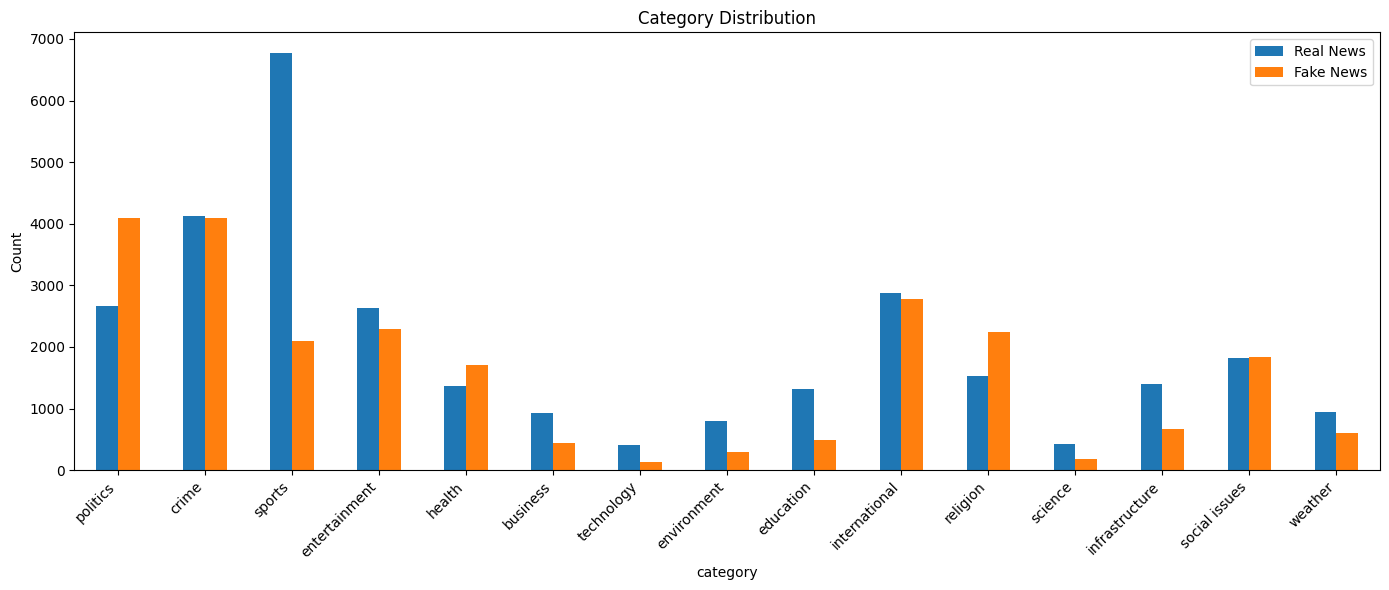

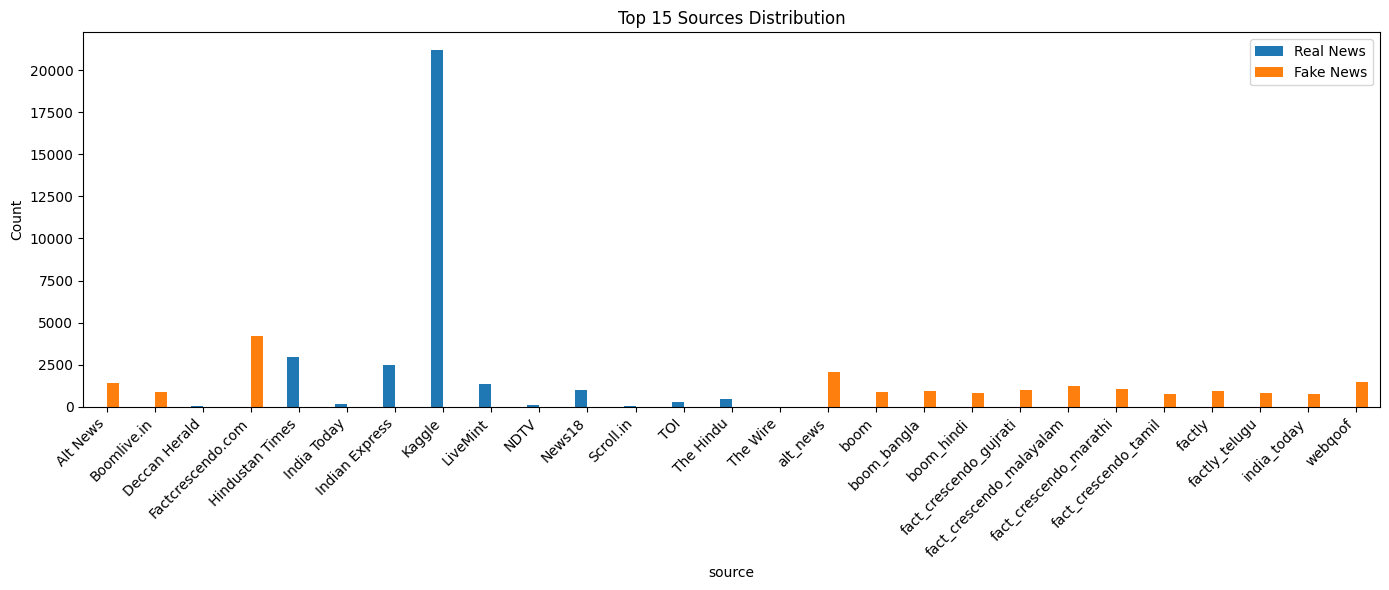

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
real_df = pd.read_csv("real_news_with_predicted_categories.csv")
fake_df = pd.read_csv("fake_news_with_predicted_categories.csv")

# Define 15 expected categories
categories = [
    "politics", "crime", "sports", "entertainment", "health", "business", "technology",
    "environment", "education", "international", "religion", "science",
    "infrastructure", "social issues", "weather"
]

# Count categories
real_cat = real_df['category'].value_counts().reindex(categories, fill_value=0)
fake_cat = fake_df['category'].value_counts().reindex(categories, fill_value=0)

# Plot category distribution
cat_df = pd.DataFrame({'Real News': real_cat, 'Fake News': fake_cat})
cat_df.plot(kind='bar', figsize=(14,6), title="Category Distribution", ylabel="Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Source distribution
real_src = real_df['source'].value_counts().head(15)
fake_src = fake_df['source'].value_counts().head(15)

src_df = pd.DataFrame({
    'Real News': real_src,
    'Fake News': fake_src
}).fillna(0).astype(int)

# Plot source comparison
src_df.plot(kind='bar', figsize=(14,6), title="Top 15 Sources Distribution", ylabel="Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm

# Supported languages and models (Helsinki)
language_map = {
    "hindi": ("Helsinki-NLP/opus-mt-hi-en", "hindi"),
    "bangla": ("Helsinki-NLP/opus-mt-bn-en", "bangla"),
    "punjabi": ("Helsinki-NLP/opus-mt-pa-en", "punjabi"),
    "tamil": ("Helsinki-NLP/opus-mt-ta-en", "tamil"),
    "malayalam": ("Helsinki-NLP/opus-mt-ml-en", "malayalam"),
    "gujrati": ("Helsinki-NLP/opus-mt-gu-en", "gujrati"),
    "marathi": ("Helsinki-NLP/opus-mt-mr-en", "marathi"),
    "urdu": ("Helsinki-NLP/opus-mt-ur-en", "urdu"),
    "assamese": ("Helsinki-NLP/opus-mt-as-en", "assamese"),
    "sinhala": ("Helsinki-NLP/opus-mt-si-en", "sinhala"),
    "burmese": ("Helsinki-NLP/opus-mt-my-en", "burmese"),
}

# Translate headlines from a file
def translate_file(file_path, output_dir="translated"):
    file_name = os.path.basename(file_path)
    print(f"\n🔁 Processing: {file_name}")

    # Match language from filename
    lang_key = next((k for k in language_map if k in file_name.lower()), None)
    if not lang_key:
        print(f"⚠️ Skipping unsupported language in: {file_name}")
        return

    model_name, lang = language_map[lang_key]

    try:
        tokenizer = MarianTokenizer.from_pretrained(model_name)
        model = MarianMTModel.from_pretrained(model_name)
    except Exception as e:
        print(f"❌ Error loading model for {lang} – {e}")
        return

    # Read Excel
    try:
        df = pd.read_excel(file_path)
    except Exception as e:
        print(f"❌ Failed to read {file_name}: {e}")
        return

    # Detect column with text
    text_col = next((col for col in df.columns if "headline" in col.lower() or "title" in col.lower()), None)
    if not text_col:
        print(f"⚠️ No 'headline' or 'title' column in {file_name}. Skipping.")
        return

    texts = df[text_col].dropna().astype(str).tolist()
    translations = []

    batch_size = 8
    print(f"🔠 Translating {len(texts)} headlines from {lang}...")

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        translated = model.generate(**inputs)
        batch_translations = tokenizer.batch_decode(translated, skip_special_tokens=True)
        translations.extend(batch_translations)

    df_translated = df.loc[df[text_col].notna()].copy()
    df_translated["translated_headline"] = translations
    df_translated["translated_from"] = lang
    df_translated["source_file"] = file_name

    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir, f"{file_name.replace('.xlsx', '')}_translated.csv")
    df_translated.to_csv(out_path, index=False)
    print(f"✅ Saved: {out_path}")

# Process all .xlsx files in a folder
def translate_folder(folder_path="factgrill", output_dir="translated"):
    for file in os.listdir(folder_path):
        if file.endswith(".xlsx"):
            translate_file(os.path.join(folder_path, file), output_dir=output_dir)

# 🚀 Run
translate_folder("factgrill", output_dir="translated")


🔁 Processing: factly_telugu.xlsx
⚠️ Skipping unsupported language in: factly_telugu.xlsx

🔁 Processing: vishwas_hindi.xlsx


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/304M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

❌ Failed to read vishwas_hindi.xlsx: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

🔁 Processing: fact_crescendo_odia.xlsx
⚠️ Skipping unsupported language in: fact_crescendo_odia.xlsx

🔁 Processing: vishwas_urdu.xlsx


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/848k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/304M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/816k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

🔠 Translating 422 headlines from urdu...


  0%|                                                         | 0/53 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/306M [00:00<?, ?B/s]

100%|████████████████████████████████████████████████| 53/53 [21:24<00:00, 24.23s/it]


✅ Saved: translated/vishwas_urdu_translated.csv

🔁 Processing: alt_news_hindi.xlsx
🔠 Translating 1758 headlines from hindi...


100%|██████████████████████████████████████████████| 220/220 [48:31<00:00, 13.24s/it]


✅ Saved: translated/alt_news_hindi_translated.csv

🔁 Processing: fact_crescendo_malayalam.xlsx


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/818k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

🔠 Translating 1251 headlines from malayalam...


  0%|                                                        | 0/157 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

  1%|▎                                            | 1/157 [01:57<5:06:45, 117.99s/it]

In [10]:
import os
from lime.lime_text import LimeTextExplainer

# Make sure model, tokenizer, predict_proba, real_df, and le are already loaded
class_names = le.classes_.tolist()
explainer = LimeTextExplainer(class_names=class_names)

# Create output folder
output_dir = "lime_explanations"
os.makedirs(output_dir, exist_ok=True)

# 🔁 Loop through N examples
N = 10  # You can increase this
for i in range(N):
    text_instance = real_df['headline'].iloc[i]
    pred_label = real_df['predicted_label'].iloc[i]

    print(f"[{i}] 📰 Headline: {text_instance}")
    print(f"    🧠 Predicted: {pred_label}")

    # Generate explanation
    exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)

    # Save as HTML
    html_path = os.path.join(output_dir, f"lime_explanation_{i}_{pred_label}.html")
    exp.save_to_file(html_path)
    print(f"    📁 Saved: {html_path}\n")

[0] 📰 Headline: Pakistan Army vows to 'respond' as India strikes terror camps
    🧠 Predicted: international


RuntimeError: Placeholder storage has not been allocated on MPS device!


🔍 Source Distribution:
source
Factcrescendo.com           4188
alt_news                    2081
webqoof                     1490
Alt News                    1410
fact_crescendo_malayalam    1250
fact_crescendo_marathi      1082
fact_crescendo_gujrati      1000
factly                       971
boom_bangla                  938
boom                         909
Boomlive.in                  903
boom_hindi                   853
factly_telugu                799
india_today                  786
fact_crescendo_tamil         760
Youturn.in                   676
India Today                  631
dfrac.org                    387
alt_news_hindi               371
fact_crescendo_odia          287
fact_crescendo               265
OpIndia                      257
vishwas                      254
Vishvasnews                  216
The Times of India           188
factchecker.in               175
thip.media                   150
SM Hoax Slayer               150
digiteye.in                  139
newschecker 

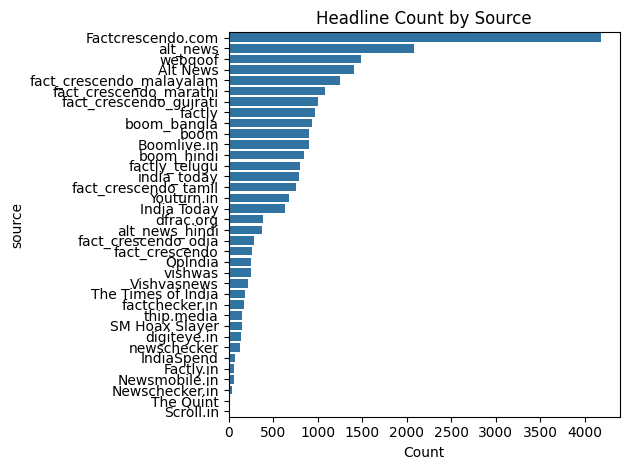


📝 Headline Length Statistics:
        char_length    word_count  avg_word_len
count  23954.000000  23954.000000  23954.000000
mean      77.065041     13.231819      4.976109
std       21.137307      3.914865      0.726078
min        2.000000      1.000000      2.000000
25%       63.000000     11.000000      4.461538
50%       75.000000     13.000000      4.909091
75%       89.000000     15.000000      5.400000
max      316.000000     56.000000     12.000000

🧠 Complex Headlines (Avg Word Length > 7):
                                                headline  avg_word_len
20164  Thiruvananthapuram-Nagercoil National Highway ...     12.000000
3959   Prannoy Roy…Hindu…Muslim…Christian…. The contr...     11.800000
20535                   Ranganathan criticized Bhagyaraj     10.000000
854                                           Loading...     10.000000
20438  Madurai parliamentary candidate Venkatesan wel...      9.400000
19538           Ramadas, Thirumavalavan Biography Image?      9.250

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from difflib import SequenceMatcher
import numpy as np

# Load your cleaned dataset
df = pd.read_csv("Final_Fake_News_Dataset.csv")  # Path to your combined file
df = df.dropna(subset=["headline"])

# ---------- 1. SOURCE DISTRIBUTION ----------
print("\n🔍 Source Distribution:")
print(df['source'].value_counts())
sns.countplot(data=df, y='source', order=df['source'].value_counts().index)
plt.title("Headline Count by Source")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# ---------- 2. HEADLINE LENGTH / COMPLEXITY ----------
df['char_length'] = df['headline'].apply(len)
df['word_count'] = df['headline'].apply(lambda x: len(str(x).split()))
df['avg_word_len'] = df['headline'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

print("\n📝 Headline Length Statistics:")
print(df[['char_length', 'word_count', 'avg_word_len']].describe())

# ---------- 3. LINGUISTIC DIVERSITY / READABILITY PROXY ----------
# Heuristic: headlines with avg word length > 7
complex_headlines = df[df['avg_word_len'] > 7][['headline', 'avg_word_len']].sort_values(by='avg_word_len', ascending=False)
print("\n🧠 Complex Headlines (Avg Word Length > 7):")
print(complex_headlines.head(10))

# ---------- 4. SEMANTIC DEDUPLICATION CANDIDATES ----------
print("\n🔁 Checking for similar headlines (may take time)...")

def find_similar_pairs(headlines, threshold=0.9):
    similar_pairs = []
    for i in range(len(headlines)):
        for j in range(i+1, len(headlines)):
            sim = SequenceMatcher(None, headlines[i], headlines[j]).ratio()
            if sim > threshold:
                similar_pairs.append((headlines[i], headlines[j], sim))
    return similar_pairs

sample_headlines = df['headline'].dropna().sample(n=200, random_state=42).tolist()
similar_headline_pairs = find_similar_pairs(sample_headlines, threshold=0.92)

print(f"\n🔍 Found {len(similar_headline_pairs)} high similarity headline pairs:")
for h1, h2, score in similar_headline_pairs[:5]:
    print(f"\nSim: {score:.2f}\n→ {h1}\n→ {h2}")


🔡 Top 20 Most Common Words (excluding stopwords):
video: 5075
viral: 3339
truth: 3228
old: 2287
fake: 2069
shared: 1922
modi: 1498
photo: 1448
know: 1372
fact: 1357
bjp: 1339
check: 1259
news: 1236
india: 1177
false: 938
gandhi: 926
police: 925
claim: 925
picture: 906
image: 759


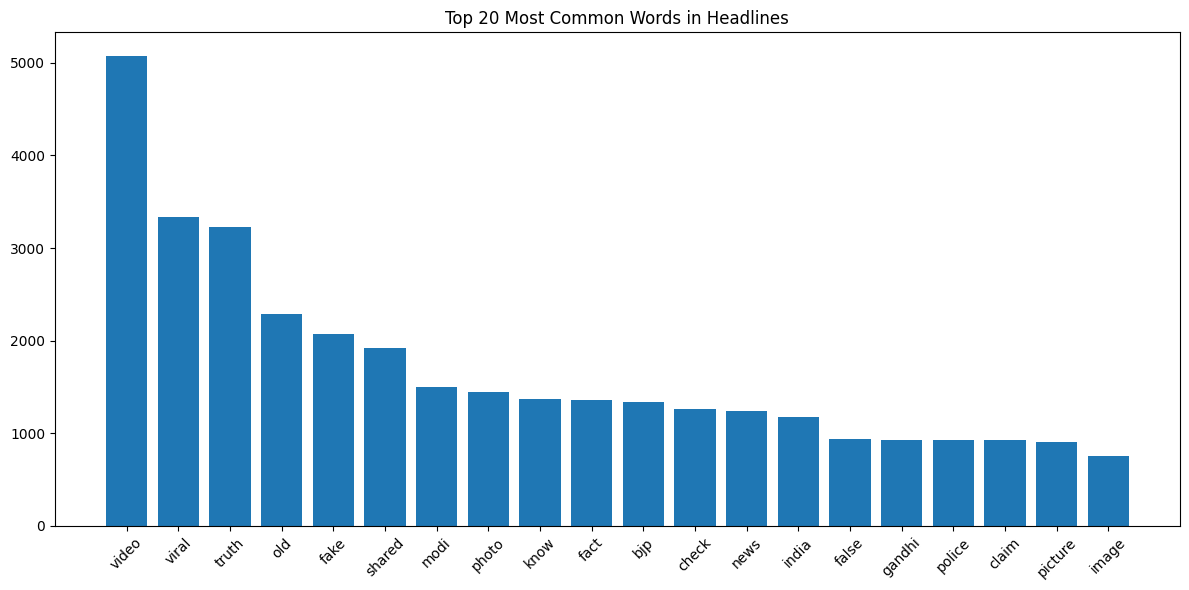

In [18]:
import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load your dataset
df = pd.read_csv("Final_Fake_News_Dataset.csv")  # or whichever CSV you’re using

# Tokenize and filter words
all_words = []

for doc in nlp.pipe(df["headline"].dropna().astype(str), disable=["ner", "parser"]):
    words = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]
    all_words.extend(words)

# Count most common words
word_freq = Counter(all_words)
top_words = word_freq.most_common(20)

# Show results
print("\n🔡 Top 20 Most Common Words (excluding stopwords):")
for word, freq in top_words:
    print(f"{word}: {freq}")

# Optional: bar plot
words, freqs = zip(*top_words)
plt.figure(figsize=(12, 6))
plt.bar(words, freqs)
plt.title("Top 20 Most Common Words in Headlines")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation phase
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# Wrapper for prediction
class_names = le.classes_.tolist()

def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.detach().cpu().numpy()

# LIME explainer
explainer = LimeTextExplainer(class_names=class_names)
i = 0  # Index of example from validation set
text_instance = val_df['headline'].iloc[i]

exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
exp.show_in_notebook(text=True)

In [27]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

In [21]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

model = DistilBertForSequenceClassification.from_pretrained("distilbert_category_model")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert_category_model")

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Evaluate
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [19]:
# Selenium Setup
from webdriver_manager.chrome import ChromeDriverManager
driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()))

def scrape_fake_news_selenium(url, selector, pages=50, source="Unknown"):
    headlines = []
    for page in tqdm(range(1, pages+1), desc=source):
        try:
            driver.get(url.format(page))
            time.sleep(2)
            elems = driver.find_elements(By.CSS_SELECTOR, selector)
            for el in elems:
                text = el.text.strip()
                if text:
                    headlines.append({"headline": text, "label": "fake", "source": source})
        except Exception as e:
            print(f"Error on page {page} of {source}: {e}")
    return headlines

fake_sources = [
    {"source": "Alt News", "url": "https://www.altnews.in/topic/fake-news/page/{}/", "selector": "h1.entry-title a"},
    {"source": "BOOM Live", "url": "https://www.boomlive.in/fake-news/{}",
     "selector": "div.card-title a"},
    {"source": "Factly", "url": "https://factly.in/category/fake-news/page/{}/", "selector": "h2.entry-title a"},
    {"source": "India Today Fact Check", "url": "https://www.indiatoday.in/fact-check?page={}",
     "selector": "h2.news-title"},
]

fake_news = []
for src in fake_sources:
    fake_news += scrape_fake_news_selenium(src['url'], src['selector'], pages=100, source=src['source'])

driver.quit()

df_fake = pd.DataFrame(fake_news)
df_fake.to_csv("data/raw_fake_news.csv", index=False)
print(df_fake.head())
print(df_fake.shape)

NameError: name 'GeckoDriverManager' is not defined


📘 Analyzing Combined Dataset

Total samples: 53954
Label distribution:
 label
real    30000
fake    23954
Name: count, dtype: int64

Category distribution:
 category
sports            8870
crime             8222
politics          6749
international     5663
entertainment     4930
religion          3779
social issues     3662
health            3067
infrastructure    2062
education         1803
weather           1552
business          1356
environment       1087
science            610
technology         542
Name: count, dtype: int64

Missing values:
 headline          0
label             0
source            0
category          0
Unnamed: 0    30000
dtype: int64

🔍 Headline Length Stats:
           char_len    word_count  avg_word_len
count  53954.000000  53954.000000  53954.000000
mean      65.872632     11.025781      5.168351
std       23.363511      4.095013      0.878571
min        2.000000      1.000000      2.000000
25%       48.000000      8.000000      4.555556
50%       64.0000

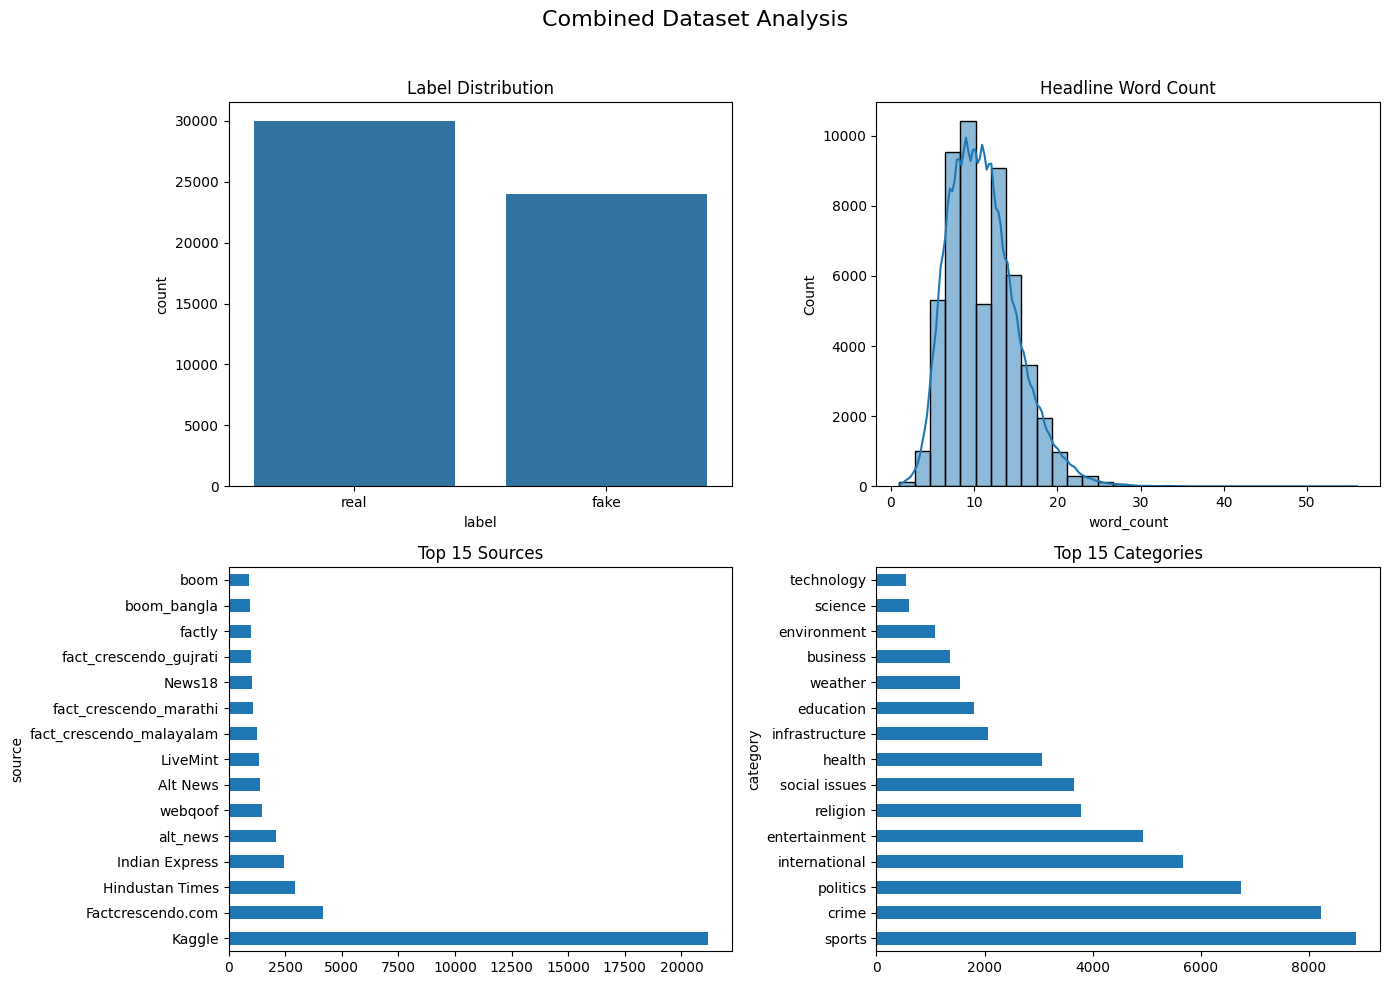


📘 Analyzing Train Dataset

Total samples: 43163
Label distribution:
 label
real    24000
fake    19163
Name: count, dtype: int64

Category distribution:
 category
sports            7062
crime             6572
politics          5384
international     4537
entertainment     3929
religion          3005
social issues     2979
health            2443
infrastructure    1658
education         1455
weather           1255
business          1097
environment        875
science            479
technology         433
Name: count, dtype: int64

Missing values:
 headline          0
label             0
source            0
category          0
Unnamed: 0    24000
dtype: int64

🔍 Headline Length Stats:
           char_len    word_count  avg_word_len
count  43163.000000  43163.000000  43163.000000
mean      65.844659     11.021361      5.168360
std       23.342173      4.095135      0.871479
min        2.000000      1.000000      2.000000
25%       48.000000      8.000000      4.562500
50%       64.000000 

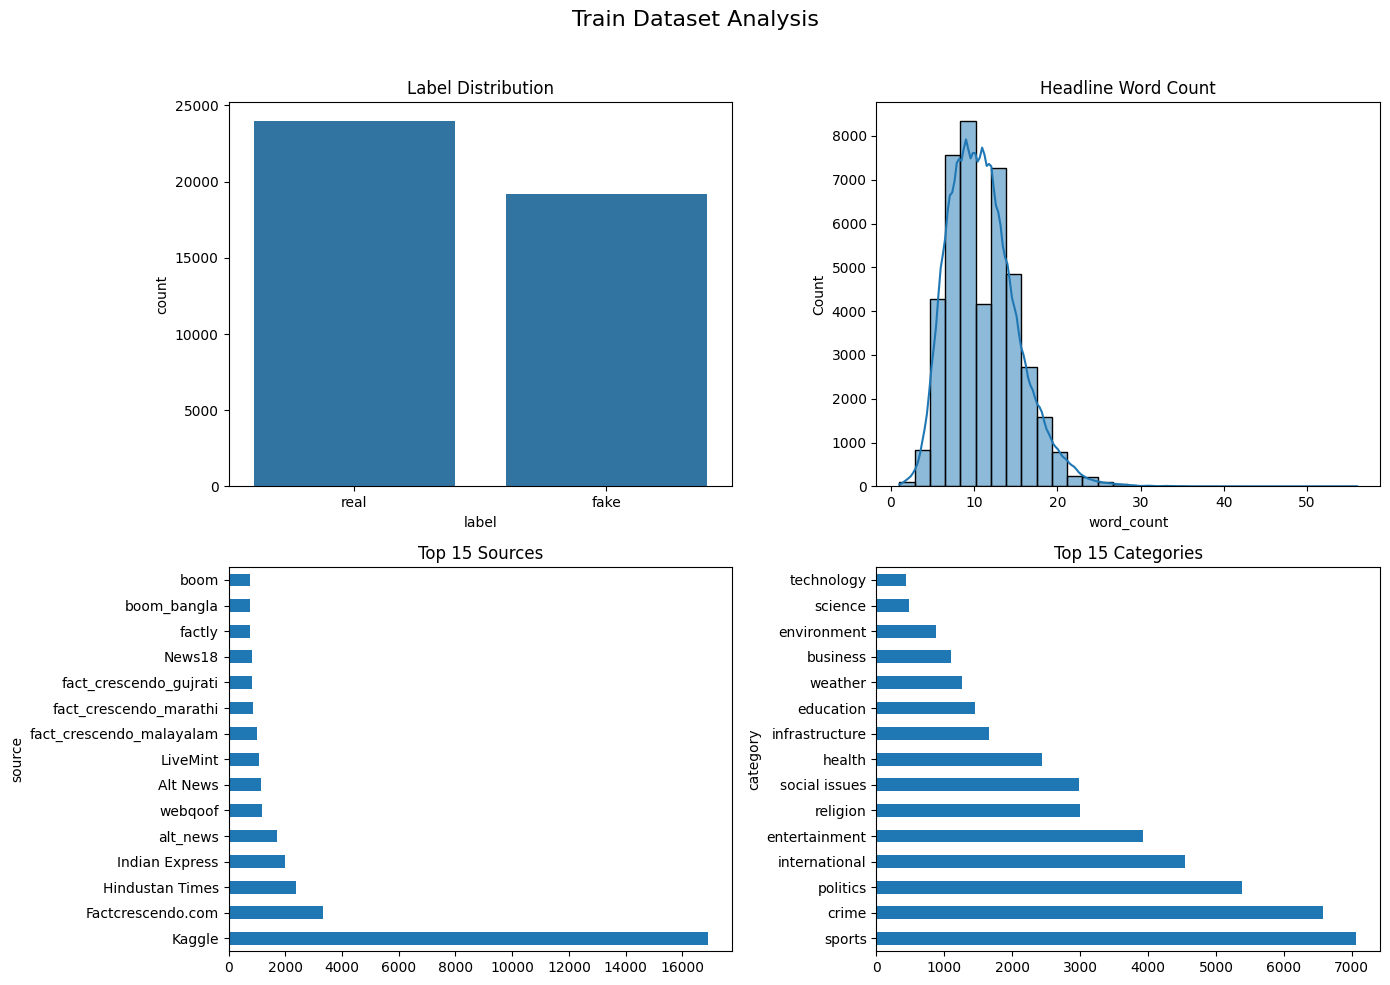


📘 Analyzing Test Dataset

Total samples: 10791
Label distribution:
 label
real    6000
fake    4791
Name: count, dtype: int64

Category distribution:
 category
sports            1808
crime             1650
politics          1365
international     1126
entertainment     1001
religion           774
social issues      683
health             624
infrastructure     404
education          348
weather            297
business           259
environment        212
science            131
technology         109
Name: count, dtype: int64

Missing values:
 headline         0
label            0
source           0
category         0
Unnamed: 0    6000
dtype: int64

🔍 Headline Length Stats:
           char_len    word_count  avg_word_len
count  10791.000000  10791.000000  10791.000000
mean      65.984524     11.043462      5.168315
std       23.449420      4.094670      0.906427
min        6.000000      1.000000      2.500000
25%       48.000000      8.000000      4.555556
50%       64.000000     11.0

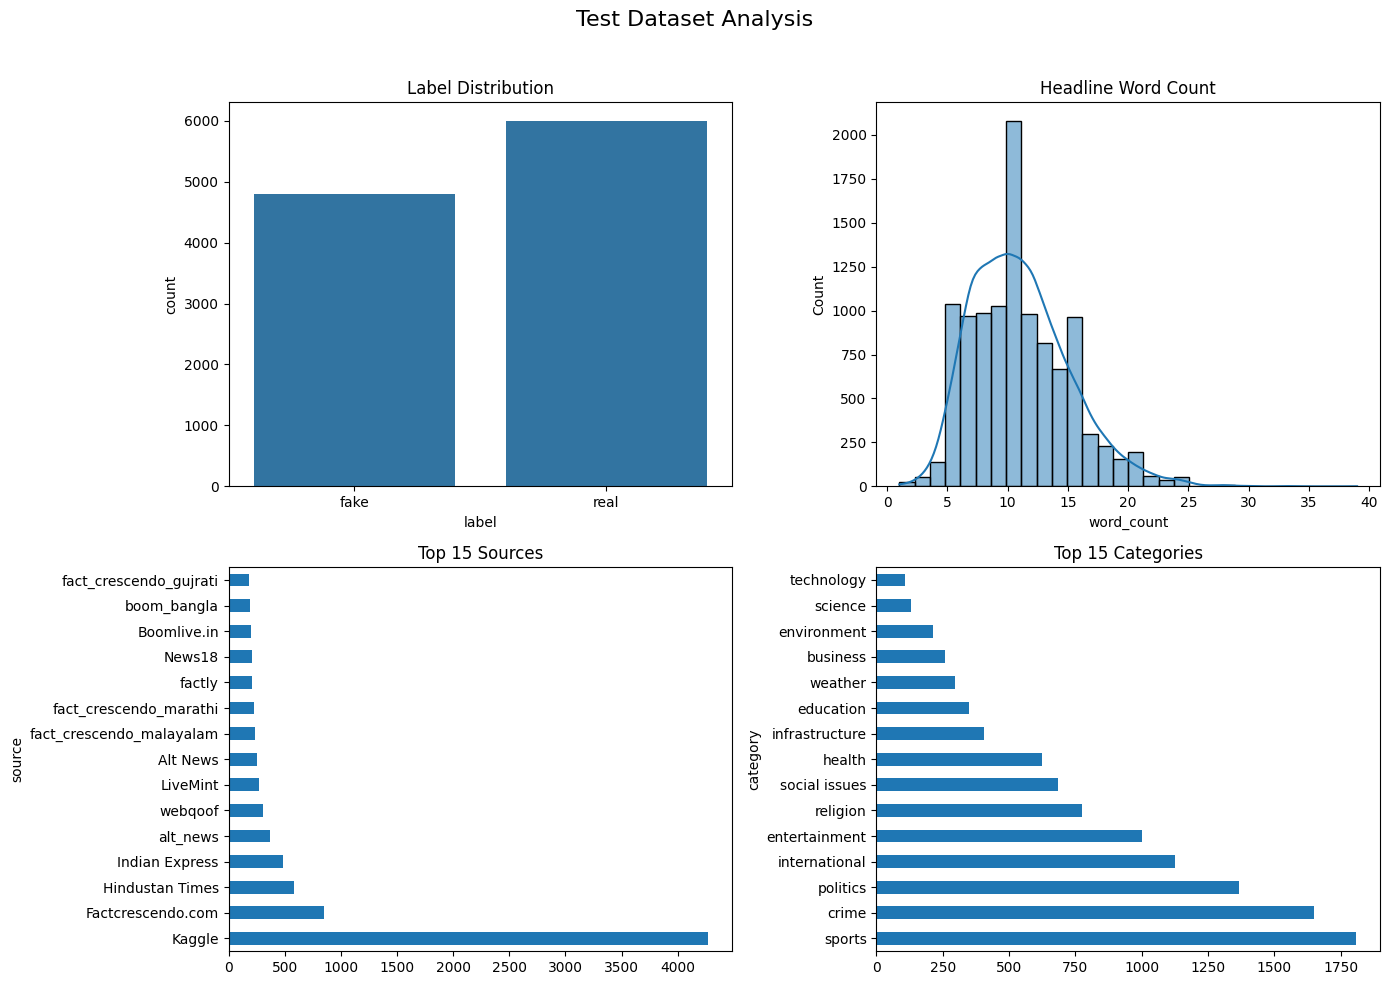

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textstat

# Load files
paths = {
    "Combined": "graphs/clean_combined_news.csv",
    "Train": "graphs/train_dataset.csv",
    "Test": "graphs/test_dataset.csv"
}

# Start analysis
for name, path in paths.items():
    print(f"\n📘 Analyzing {name} Dataset")
    df = pd.read_csv(path)

    # Basic stats
    print(f"\nTotal samples: {len(df)}")
    print("Label distribution:\n", df['label'].value_counts())
    print("\nCategory distribution:\n", df['category'].value_counts())
    print("\nMissing values:\n", df.isnull().sum())

    # Headline metrics
    df['char_len'] = df['headline'].astype(str).apply(len)
    df['word_count'] = df['headline'].astype(str).apply(lambda x: len(x.split()))
    df['avg_word_len'] = df['headline'].astype(str).apply(lambda x: sum(len(w) for w in x.split()) / max(len(x.split()), 1))
    df['reading_ease'] = df['headline'].astype(str).apply(lambda x: textstat.flesch_reading_ease(x))

    print("\n🔍 Headline Length Stats:")
    print(df[['char_len', 'word_count', 'avg_word_len']].describe())

    print("\n📖 Avg Flesch Reading Ease:", round(df['reading_ease'].mean(), 2))

    # Visualizations
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"{name} Dataset Analysis", fontsize=16)

    sns.countplot(data=df, x='label', ax=axs[0, 0])
    axs[0, 0].set_title("Label Distribution")

    sns.histplot(df['word_count'], bins=30, kde=True, ax=axs[0, 1])
    axs[0, 1].set_title("Headline Word Count")

    top_sources = df['source'].value_counts().nlargest(15)
    top_sources.plot(kind='barh', ax=axs[1, 0])
    axs[1, 0].set_title("Top 15 Sources")

    top_categories = df['category'].value_counts().nlargest(15)
    top_categories.plot(kind='barh', ax=axs[1, 1])
    axs[1, 1].set_title("Top 15 Categories")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [23]:
import pandas as pd

# Load dataset
df = pd.read_csv("fake_news_with_predicted_categories.csv")

# Ensure lowercase for consistency
df['headline'] = df['headline'].astype(str).str.lower()
df['source'] = df['source'].astype(str).str.lower()

# Define heuristics
satire_terms = ['satire', 'parody', 'spoof', 'faking news', 'sarcasm']
opinion_terms = ['opinion', 'editorial', 'column', 'viewpoint', 'commentary']
truth_phrases = ['fact check confirms', 'true', 'verified', 'confirmed']
suspicious_sources = ['fakingnews', 'thedailystar', 'theonion']  # extend if needed

# Apply flags
df['satire_flag'] = df['headline'].apply(lambda x: any(term in x for term in satire_terms))
df['opinion_flag'] = df['headline'].apply(lambda x: any(term in x for term in opinion_terms))
df['truthy_flag'] = df['headline'].apply(lambda x: any(term in x for term in truth_phrases))
df['suspicious_source_flag'] = df['source'].apply(lambda x: any(term in x for term in suspicious_sources))

# Combine flags for suspicious "fake" headlines
suspicious_fakes = df[
    (df['label'] == 'fake') & (
        df['satire_flag'] |
        df['opinion_flag'] |
        df['truthy_flag'] |
        df['suspicious_source_flag']
    )
]

# Save for manual review
suspicious_fakes[['headline', 'source', 'category']].to_csv("suspicious_fake_labels.csv", index=False)
print(f"✅ Suspicious entries saved: {len(suspicious_fakes)}")

✅ Suspicious entries saved: 580


In [24]:
import pandas as pd

# Load main fake-labeled dataset and the suspicious list
df = pd.read_csv("fake_news_with_predicted_categories.csv")
suspicious = pd.read_csv("suspicious_fake_labels.csv")

# Optional: Check how many overlap
print(f"Suspicious headlines found in dataset: {len(suspicious)}")

# Option 1: Mark suspicious entries
df["suspicious"] = df["headline"].isin(suspicious["headline"])

# Option 2: Remove suspicious ones (if you want a cleaner set)
df_cleaned = df[~df["suspicious"]].copy()

# Save the marked or cleaned dataset
df.to_csv("fake_news_with_suspicion_flag.csv", index=False)
df_cleaned.to_csv("cleaned_fake_news.csv", index=False)

print("✅ Files saved: 'fake_news_with_suspicion_flag.csv' and 'cleaned_fake_news.csv'")

Suspicious headlines found in dataset: 580
✅ Files saved: 'fake_news_with_suspicion_flag.csv' and 'cleaned_fake_news.csv'


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load combined dataset
df = pd.read_csv("graphs/clean_combined_news.csv")

# First, split train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Then split temp into val (10%) and test (10%) from the original total
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

# Save splits
train_df.to_csv("data/train_dataset.csv", index=False)
val_df.to_csv("data/val_dataset.csv", index=False)
test_df.to_csv("data/test_dataset.csv", index=False)

# Optional: Show counts
print("✅ Split Summary:")
print(f"Train: {train_df.shape}, Real: {train_df['label'].value_counts().to_dict()}")
print(f"Val:   {val_df.shape}, Real: {val_df['label'].value_counts().to_dict()}")
print(f"Test:  {test_df.shape}, Real: {test_df['label'].value_counts().to_dict()}")

✅ Split Summary:
Train: (43163, 5), Real: {'real': 24000, 'fake': 19163}
Val:   (5395, 5), Real: {'real': 3000, 'fake': 2395}
Test:  (5396, 5), Real: {'real': 3000, 'fake': 2396}


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textstat
import os

# Load from data/ folder
train = pd.read_csv("data/train_dataset.csv")
val = pd.read_csv("data/val_dataset.csv")
test = pd.read_csv("data/test_dataset.csv")

# Output folder for saving plots
os.makedirs("data/analysis_plots", exist_ok=True)

# Analysis function
def analyze(df, name):
    print(f"\n📊 {name} Dataset")
    print(f"Total samples: {len(df)}")

    # Label Distribution
    print("\nLabel distribution:")
    print(df['label'].value_counts(normalize=True).round(3))

    # Category Distribution
    print("\nCategory distribution:")
    print(df['category'].value_counts(normalize=True).round(3))

    # Source Distribution
    print("\nTop 10 Sources:")
    print(df['source'].value_counts().head(10))

    # Headline Stats
    df['char_len'] = df['headline'].str.len()
    df['word_count'] = df['headline'].str.split().apply(len)
    df['avg_word_len'] = df['headline'].apply(lambda x: sum(len(w) for w in x.split()) / max(len(x.split()), 1))
    df['readability'] = df['headline'].apply(textstat.flesch_reading_ease)

    print(f"\nAverage headline length: {df['char_len'].mean():.2f} characters")
    print(f"Average Flesch Reading Ease: {df['readability'].mean():.2f}")

    print("\n🔍 Diversity:")
    print(f"Unique Sources: {df['source'].nunique()}")
    print(f"Unique Categories: {df['category'].nunique()}")

    # Plots
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x='label')
    plt.title(f"{name} Label Balance")
    plt.savefig(f"data/analysis_plots/{name}_label_dist.png")
    plt.close()

    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, y='category', order=df['category'].value_counts().index)
    plt.title(f"{name} Category Distribution")
    plt.savefig(f"data/analysis_plots/{name}_category_dist.png")
    plt.close()

    plt.figure(figsize=(10, 4))
    top_sources = df['source'].value_counts().nlargest(10).index
    sns.countplot(data=df[df['source'].isin(top_sources)], y='source', order=top_sources)
    plt.title(f"{name} Top 10 Sources")
    plt.savefig(f"data/analysis_plots/{name}_top_sources.png")
    plt.close()

# Run analysis on each split
analyze(train, "Train")
analyze(val, "Validation")
analyze(test, "Test")


📊 Train Dataset
Total samples: 43163

Label distribution:
label
real    0.556
fake    0.444
Name: proportion, dtype: float64

Category distribution:
category
sports            0.164
crime             0.152
politics          0.125
international     0.105
entertainment     0.091
religion          0.070
social issues     0.069
health            0.057
infrastructure    0.038
education         0.034
weather           0.029
business          0.025
environment       0.020
science           0.011
technology        0.010
Name: proportion, dtype: float64

Top 10 Sources:
source
Kaggle                      16909
Factcrescendo.com            3342
Hindustan Times              2374
Indian Express               1977
alt_news                     1714
webqoof                      1184
Alt News                     1159
LiveMint                     1067
fact_crescendo_malayalam     1015
fact_crescendo_marathi        857
Name: count, dtype: int64

Average headline length: 65.84 characters
Average Flesch 

In [ ]:
df_real = pd.read_csv("data/raw_real_news.csv")
df_fake = pd.read_csv("data/raw_fake_news.csv")

df_combined = pd.concat([df_real, df_fake]).drop_duplicates('headline').dropna(subset=['headline'])

print(df_combined['label'].value_counts())
df_combined.to_csv("data/clean_combined.csv", index=False)

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/clean_combined.csv")

train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train.to_csv("data/train_dataset.csv", index=False)
test.to_csv("data/test_dataset.csv", index=False)

print(f"Train size: {train.shape}, Test size: {test.shape}")